In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
from matplotlib import cm
import pandas as pd
import numpy as np
import time
import random as rand
import copy
import gc
import math
from datetime import datetime

# NeuroEvolution of Augmenting Topologies (NEAT)
## to solve a missile guidance problem

## Abstract

Welcome to our NEAT python notebook!

This notebook lays out a framework to solve problems using the NEAT algorithm - based on this paper by Kenneth O. Stanley and Risto Miikkulainen: http://nn.cs.utexas.edu/downloads/papers/stanley.ec02.pdf

The example we use in this notebook is that of a 2D missile guidance problem, but the framework has been made to plug in any potential problem that can be solved by NEAT.

The NEAT algorithm is a type of NeuroEvolutionary algorithm - one which we evolve artificial neural network (ANN) topologies over a series of generations to find an ANN that can solve our problem. Evolutionary learning is an untraditional but effective way to train a neural network to solve certain tasks. Tasks that are suitable to be solved by NeuroEvolutionary algorithms are ones where the success of the network is measured over a series of moves. This differs from networks that we train by more conventional methods such as back-propogation as these networks require supervision on every 'move' they make. 

It would be unsuitable to use NEAT to train a neural network to solve a classification task, because every training move requires supervision, a yes or no answer. It would be much more effective training a network like this using traditional methods such as back propogation. 
Tasks that should be solved by an ANN trained with NEAT are tasks where the success of each ANN can only be measured over a series of moves, because each individual move does not have a right or wrong answer. For example, training a network to play a game, or guiding a missile to the end of a level (as you shall see).

The first 4/5 of this document are defining functions to be used by the NEAT algorithm. Each one of these functions has a description at the beginning outlining its role in NEAT. The last part of this document contains the NEAT algorithm itself followed by the network training and the visualization. 

## Level Generator

The level generator makes a level which is used by the ANNs in the NEAT algorithm for training. It is the level that the missile must navigate to complete the task.

This function generates a simple tunnel which our missile must pass through to reach it's target at the other end. Firstly, a matrix of set height and length containing only 0s, which represents areas that the missile can't pass through. Then a passage of 1s of random direction and uniform width is carved out of this matrix, where 1s represent areas the missile can pass through. The function will then output a visual representation of this.

In [2]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

**Inputs:**<br>
lvl_height - *level pixel height* <br>
lvl_length - *level pixel length* <br>
lvl_difficulty - *level difficulty 0-1* <br>

In [3]:
def level_generator(lvl_height,lvl_length,difficulty):   
    %matplotlib notebook
    
    global height
    global length
    global data

    height = lvl_height # height of the path
    length = lvl_length # length of the path
    width = 10 # uniform width of tunnel

    # populating the area with all blocks
    data= np.zeros((height, length+30))

    # initial probabilities of step (up or down) and width (thick or thin) of tunnel (50/50 to begin with)
    stepprob1 = 0.5
    stepprob2 = 1- stepprob1
    widthprob1 = 0.5
    widthprob2 = 1- widthprob1

    # clearing a random tunnel opening for the missile    
    for i in range (0,length+30):
        for j in range (0,height):
            if i == 0:
                for x in range (((height-width)//2), ((height+width)//2)): #sets the initial opening
                    data[x, i] = 1

            # clearing a random path from the initial tunnel opening              
            elif data[j, i-1] == 1:

                # sets the direction of tunnel step movement (up or down)
                if j < 3:
                    upordown = 0
                elif (j + width) > (height-3):
                    upordown = 1
                else:
                    upordown = np.random.choice(2, p=[stepprob1,stepprob2])

                if upordown == 0:
                    step = j + 1
                    stepprob1 = difficulty
                    stepprob2 = 1 - stepprob1
                elif upordown == 1:
                    step = j - 1
                    stepprob2 = difficulty
                    stepprob1 = 1 - stepprob2

                for y in range (step, (step+width)):
                    data[y, i] = 1
                break

    # plot figure of tunnel
    plt.matshow(data[0:30,0:length], cmap=colors.ListedColormap(['lime', 'black']))
    plt.show()

Lets generate a level for our missile to navigate!

<IPython.core.display.Javascript object>


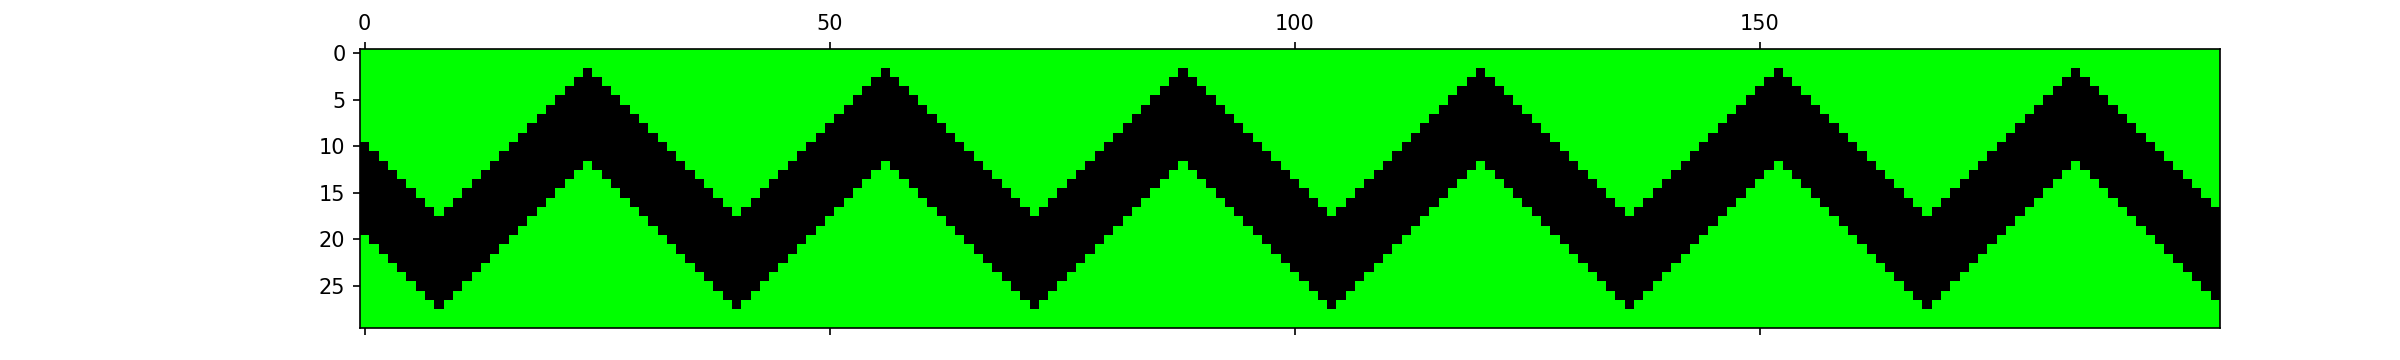

In [4]:
level_generator(30,200,1)

## Commands/Plotting Functions

Below, the various commands that the missile can interpret are defined. Although the missile will always be moving uniformly from left to right through the level, it can simultaneously interpret three other movements; up, down, or straight. The missile is represented on the matrix as two adjacent values of 3. The plotting functions are used to view a missiles journey.

In [5]:
# command to move missile up
def moveUp():
    global y
    global x1
    global x2
    global xlim1
    global xlim2
    
    data[y,x1] = 1
    data[y,x2] = 1
    
    y += -1
    x1 += 1
    x2 += 1
    xlim1 += 1
    xlim2 += 1
    
    data[y,x1] = data[y,x1] +2
    data[y,x2] = data[y,x2] +2

# command to move missile down
def moveDown():
    global y
    global x1
    global x2
    global xlim1
    global xlim2
    
    data[y,x1] = 1
    data[y,x2] = 1
    
    y += +1
    x1 += 1
    x2 += 1
    xlim1 += 1
    xlim2 += 1
    
    data[y,x1] = data[y,x1] +2
    data[y,x2] = data[y,x2] +2

# command to move missile straight
def moveStraight():
    global y
    global x1
    global x2
    global xlim1
    global xlim2
    
    data[y,x1] = 1
    data[y,x2] = 1
    
    x1 += 1
    x2 += 1
    xlim1 += 1
    xlim2 += 1
    
    data[y,x1] = data[y,x1] +2
    data[y,x2] = data[y,x2] +2

# plots visual for each step if missile hasn't crashed (neural vis)
def plotFig_nn(sleeptime):
    global fig
    global data
    global xlim1
    global xlim2
    global cmap
    global length
    
    if xlim2 >= length:
        y_finish = np.arange(0,30,2)
        x_finish = np.ones(len(y_finish))*(30 - (xlim2-length))
        plt.plot(x_finish,y_finish,'ks',markersize=9)
        x_finish = np.ones(len(y_finish))*(31 - (xlim2-length))
        plt.plot(x_finish,y_finish,'ws',markersize=9)
        y_finish = np.arange(1,31,2)
        x_finish = np.ones(len(y_finish))*(30 - (xlim2-length))
        plt.plot(x_finish,y_finish,'ws',markersize=9)
        x_finish = np.ones(len(y_finish))*(31 - (xlim2-length))                                   
        plt.plot(x_finish,y_finish,'ks',markersize=9)

    plt.imshow(data[0:height,xlim1:xlim2], cmap=cmap)
    plt.xlim(0, 2*height)
    fig.canvas.draw()
    time.sleep(sleeptime)

# plots visual for each step if missile has crashed (neural vis)
def plotFailFig_nn():
    global y
    global x1
    global x2
    global fig
    global data
    global xlim1
    global xlim2
    global cmapfail
    global fig
    global length
    
    if xlim2 >= length:
        y_finish = np.arange(0,30,2)
        x_finish = np.ones(len(y_finish))*(30 - (xlim2-length))
        plt.plot(x_finish,y_finish,'ks',markersize=9)
        x_finish = np.ones(len(y_finish))*(31 - (xlim2-length))
        plt.plot(x_finish,y_finish,'ws',markersize=9)                                
        y_finish = np.arange(1,31,2)
        x_finish = np.ones(len(y_finish))*(30 - (xlim2-length))
        plt.plot(x_finish,y_finish,'ws',markersize=9)
        x_finish = np.ones(len(y_finish))*(31 - (xlim2-length))                                   
        plt.plot(x_finish,y_finish,'ks',markersize=9)
        
    if data[y,x1] == 2 and data[y,x2] == 2:
        plt.imshow(data[0:height,xlim1:xlim2], cmap=cmapfail) 
    else:
        plt.imshow(data[0:height,xlim1:xlim2], cmap=cmap)
    plt.xlim(0, 2*height)
    fig.canvas.draw()
    
    
def missileReset():
    global y
    global x1
    global x2
    global data
    global xlim1
    global xlim2
    global cmap
    global cmapfail
    
    y = height//2
    x1 = 1
    x2 = 2
    xlim1 = 0
    xlim2 = height
    cmap = colors.ListedColormap(['lime', 'black', 'red', 'white'])
    cmapfail = colors.ListedColormap(['lime', 'black', 'red'])
    data[y,x1] = 3
    data[y,x2] = 3

## Dynamic Network Viewer

This function plots the path of a missile, and shows the network responsible for it's various movements. Here we can see how the network is making it's decisions at each step in the missile's journey. This will become more obvious near the end when this function is called..

**Inputs:**<br>
network - *the network to view* <br>
sleeptime - *the time in seconds between each update*

In [6]:
def network_viewer_dynamic(network,sleeptime):
    global height
    global length
    global y
    global x1
    global x2
    global fig
    global data
    global xlim1
    global xlim2
    global cmapfail
    global fig
    
    %matplotlib notebook

    input_x = 15
    input_y = 30

    layers=[]
    active_neurones=[]
    outgoing =[]

    
    # read in relevant information from network
    neurones = network.neurones

    for neurone in neurones:
        layers.append(neurone.layer)
        if neurone.outgoing_connections:
            active_neurones.append(neurone.id)
            sublist = []

            for c in neurone.outgoing_connections:

                sublist.append(c.neurone_end.id)

            outgoing.append(sublist)

    data_pos = []

    # create array of plot coordinates for input neurones
    for y in range (0,input_y):
        for x in range (0,input_x):
            data_pos.append([x+6,y])

    # create array of plot coordinates for output neurones
    for i in range (1,4):
        data_pos.append([height*2,((i*height)//4)])

    # create list of hidden layers
    hidden_layers = list(set(layers))
    hidden_layers.remove(0)
    hidden_layers.remove(len(set(layers))-1)

    # assign hidden neurones plot coordinates
    for i in range(0,len(hidden_layers)):
        pos_x = (((i+1)*height)//(len(hidden_layers)+1)) + height
        pos_y = []
        for j in range(0,layers.count(hidden_layers[i])):
            pos_y.append(((j+1)*height)//(layers.count(hidden_layers[i])+1))
            data_pos.append([pos_x,pos_y[j]])
    
    active_layers = []

    for i in range(0,len(active_neurones)):
        if active_neurones[i] >= input_x * input_y:
            active_layers.append(layers[active_neurones[i]])

    hidden_active_neurones = active_neurones[(len(active_neurones)-len(active_layers)):len(active_neurones)]
    hidden_active_neurones = [hidden_active_neurones for _,hidden_active_neurones in sorted(zip(active_layers,hidden_active_neurones))]
    active_data_pos = data_pos[(len(data_pos)-len(active_layers)):len(data_pos)]
    active_data_pos = [active_data_pos for _,active_data_pos in sorted(zip(hidden_active_neurones,active_data_pos))]
    
    sorted_active_neurones = active_neurones.copy()
    active_layers = sorted(active_layers)

    for i in range(0,len(active_layers)):
        data_pos.pop()
        sorted_active_neurones.pop()

    for i in range(0,len(active_layers)):
        data_pos.append(active_data_pos[i])
        sorted_active_neurones.append(hidden_active_neurones[i])
    
    userinput = fitness_function_movedata(network)
    
    missileReset()

    # plot formatting/setup
    labels = ["Up","Down","Straight"]
    ylabels = [(height//4),((2*height)//4),((3*height)//4)]
    msize = 6
    lwidth = 1

    plt.close()
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    plt.imshow(data[0:height,xlim1:xlim2], cmap=cmap)
    plt.tick_params(axis='x',bottom=False,labelbottom=False)
    plt.tick_params(axis='y',right=False, labelright=True)
    plt.tick_params(axis='y',left=False, labelleft=False)
    plt.xlim(0, 2*height)
    plt.show()
    fail = False

    e = {}
    for step_move in range (0,length-3):
        plt.cla()
        for i in range(0,len(active_neurones)):
            for j in range(0,len(outgoing[i])):
                e["active" + str(outgoing[i][j])] = False

        # plot active/inactive neurones and connections
        for j in range(0,len(sorted_active_neurones)):
            for i in range(0,len(active_neurones)):
                if sorted_active_neurones[j] == active_neurones[i]:
                    break

            if (active_neurones[i] <= ((input_x*input_y)+2) and 
                data[data_pos[active_neurones[i]][1],(data_pos[active_neurones[i]][0]+(step_move+1))] == 1 or 
                active_neurones[i] >= ((input_x*input_y)+3) and e["active"+str(active_neurones[i])] == True):

                act_neurone = 'rs'
                act_conn = 'r-'
            else:
                act_neurone = 'ks'
                act_conn = 'k-'

            plt.plot(*zip(data_pos[active_neurones[i]]),act_neurone,markersize=msize)

            for k in range(0,len(outgoing[i])):
                plt.plot([data_pos[active_neurones[i]][0],data_pos[outgoing[i][k]][0]]
                         ,[data_pos[active_neurones[i]][1],data_pos[outgoing[i][k]][1]],act_conn,linewidth=lwidth)
                if e["active" + str(outgoing[i][k])] == False:
                    plt.plot(*zip(data_pos[outgoing[i][k]]),act_neurone,markersize=msize)

            if (active_neurones[i] <= ((input_x*input_y)+2) and 
                data[data_pos[active_neurones[i]][1],(data_pos[active_neurones[i]][0]+(step_move+1))] == 1 or 
                active_neurones[i] >= ((input_x*input_y)+3) and e["active"+str(active_neurones[i])] == True):
                for j in range(0,len(outgoing[i])):
                    e["active" + str(outgoing[i][j])] = True
            
            if userinput[step_move] == 0:
                plt.plot(*zip(data_pos[input_x*input_y]),'rs',markersize=10)
                plt.plot(*zip(data_pos[(input_x*input_y)+1]),'ks',markersize=10)
                plt.plot(*zip(data_pos[(input_x*input_y)+2]),'ks',markersize=10)
                
            elif userinput[step_move] == 1:     
                plt.plot(*zip(data_pos[input_x*input_y]),'ks',markersize=10)
                plt.plot(*zip(data_pos[(input_x*input_y)+1]),'rs',markersize=10)
                plt.plot(*zip(data_pos[(input_x*input_y)+2]),'ks',markersize=10)
                
            elif userinput[step_move] == 2:    
                plt.plot(*zip(data_pos[input_x*input_y]),'ks',markersize=10)
                plt.plot(*zip(data_pos[(input_x*input_y)+1]),'ks',markersize=10)
                plt.plot(*zip(data_pos[(input_x*input_y)+2]),'rs',markersize=10)

        plt.yticks(ylabels,labels)

        if userinput[step_move] == 0: # input of 0 = moveUp
            moveUp()

            # reset after missile crash
            if data[y,x1] == 2 or data[y,x2] == 2:
                plotFailFig_nn()
                fail = True
                break

            plotFig_nn(sleeptime)

        elif userinput[step_move] == 1: # input of 1 = moveDown
            moveDown()

            # reset after missile crash
            if data[y,x1] == 2 or data[y,x2] == 2:
                plotFailFig_nn()
                fail = True
                break

            plotFig_nn(sleeptime)

        elif userinput[step_move] == 2: # input of 2 = moveStraight
            moveStraight()

            # reset after missile crash
            if data[y,x1] == 2 or data[y,x2] == 2:
                plotFailFig_nn()
                fail = True
                break

            plotFig_nn(sleeptime)

        else:
            print("Invalid input.")
            i += -1

    if fail == True:
        score = ((x2-1)/(length-1))*100
    else:
        score = (x2/(length-1))*100

    fail = False
    data[y,x1] = data[y,x1] - 2
    data[y,x2] = data[y,x2] - 2


    print("Network", network.id,":",score,"%")

## Static Network Viewer

This function will allow us to view the topology of a given ANN. Again, this will become clearer later when we use this function.

**Inputs:**<br>
network - *the network to view*

In [7]:
def network_viewer_static(network):
    %matplotlib notebook

    layers=[]
    active_neurones=[]
    outgoing =[]
    
    
    labels = ["Up","Down","Straight"]
    ylabels = [(height//4),((2*height)//4),((3*height)//4)]
    msize = 6
    lwidth = 1

    input_x = 15
    input_y = 30

    # read in relevant information from network
    neurones = network.neurones

    for neurone in neurones:
        layers.append(neurone.layer)
        if neurone.outgoing_connections:
            active_neurones.append(neurone.id)
            sublist = []

            for c in neurone.outgoing_connections:

                sublist.append(c.neurone_end.id)

            outgoing.append(sublist)

    data_pos = []

    # create array of plot coordinates for input neurones
    for y in range (0,input_y):
        for x in range (0,input_x):
            data_pos.append([x+6,y])

    # create array of plot coordinates for output neurones
    for i in range (1,4):
        data_pos.append([height*2,((i*height)//4)])

    # create list of hidden layers
    hidden_layers = list(set(layers))
    hidden_layers.remove(0)
    hidden_layers.remove(len(set(layers))-1)

    # assign hidden neurones plot coordinates
    for i in range(0,len(hidden_layers)):
        pos_x = (((i+1)*height)//(len(hidden_layers)+1)) + height
        pos_y = []
        for j in range(0,layers.count(hidden_layers[i])):
            pos_y.append(((j+1)*height)//(layers.count(hidden_layers[i])+1))
            data_pos.append([pos_x,pos_y[j]])

    active_layers = []

    for i in range(0,len(active_neurones)):
        if active_neurones[i] >= input_x * input_y:
            active_layers.append(layers[active_neurones[i]])

    hidden_active_neurones = active_neurones[(len(active_neurones)-len(active_layers)):len(active_neurones)]
    hidden_active_neurones = [hidden_active_neurones for _,hidden_active_neurones in sorted(zip(active_layers,hidden_active_neurones))]
    active_data_pos = data_pos[(len(data_pos)-len(active_layers)):len(data_pos)]
    active_data_pos = [active_data_pos for _,active_data_pos in sorted(zip(hidden_active_neurones,active_data_pos))]

    for i in range(0,len(active_layers)):
        data_pos.pop()

    for i in range(0,len(active_layers)):
        data_pos.append(active_data_pos[i])
    

    fig = plt.figure()
    ax = plt.subplot(111)

    
    ax.tick_params(axis='x',bottom=False,labelbottom=False)
    ax.tick_params(axis='y',right=False, labelright=True)
    ax.tick_params(axis='y',left=False, labelleft=False)
    ax.set_xlim(0, 2*height)

    # plot active/inactive neurones and connections
    for i in range(0,len(active_neurones)):
        if active_neurones[i] <= (input_x*input_y):
            act_neurone = 'gs'
        else:
            act_neurone = 'bs'
            
        act_conn = 'k-'

        ax.plot(*zip(data_pos[active_neurones[i]]),act_neurone,markersize=msize)

        for k in range(0,len(outgoing[i])):
            ax.plot([data_pos[active_neurones[i]][0],data_pos[outgoing[i][k]][0]]
                     ,[data_pos[active_neurones[i]][1],data_pos[outgoing[i][k]][1]],act_conn,linewidth=lwidth)
    
    ax.plot(*zip(data_pos[(input_x*input_y)]),'rs',markersize=10)
    ax.plot(*zip(data_pos[(input_x*input_y)+1]),'rs',markersize=10)
    ax.plot(*zip(data_pos[(input_x*input_y)+2]),'rs',markersize=10)
    
    red_patch = mpatches.Patch(color='red', label='The red data')
    blue_patch = mpatches.Patch(color='blue', label='The blue data')

    legend_elements = [mpatches.Patch(color='g', label='Input'),
                      mpatches.Patch(color='b', label='Hidden'),
                      mpatches.Patch(color='r', label='Output')]
    
    ax.set_yticks(ylabels)
    ax.set_yticklabels(labels)
    ax.legend(handles=legend_elements, handlelength=0.7)
    ax.set_ylim(0,30)
    ax.invert_yaxis()

## Networks Representation

We define the objects to represent a neural network that will be passed around and used in the NEAT algorithm.

In [8]:
class Network:
    def __init__(self,id):
        self.id =id
        self.neurones = []
        self.fitness = 0
        self.temp_fitness = 0
        self.max_layer = 0
        self.current_neurone_id =0
        self.neurone_dictionary = dict({})
        self.evolved_from = self
        self.species_id = 0
        self.complexity = 0

class Neurone:
    def __init__(self,id):
        self.id = id
        self.layer = 0 
        self.current_value = 0
        self.outgoing_connections = [] 
        
class Connection:
    def __init__(self, neurone_start, neurone_end, weight):
        self.weight = weight
        self.neurone_start=neurone_start
        self.neurone_end=neurone_end
    
    def changeRandWeight(self):
        self.weight = abs(np.random.randn())

## Initialize Networks

This function is for initializing a set number of ANNs with a given number of inputs and outputs. 

**Inputs** : <br>
no_networks - *how many ANNs to initialize*  <br>
prob - *probability of making a connection between each each input and output node*<br>
n_inputs - *no. of input nodes*<br>
n_outputs - *no. of output nodes*<br>

**Outputs** : <br>
networks_master - *the master list of [Network] objects made by the initialization*

In [9]:
def initialize_networks(no_networks, prob, n_inputs, n_outputs): 
    
    connection_prob = prob
    
    #master network list containing all networks (which contain all genes and neurones)
    NETWORKS_MASTER = []
    
    for i in range(no_networks):
        #input
        network_temp = Network(i)
        layer = 0
        for j in range(n_inputs):
            neurone_temp = Neurone(j)
            neurone_temp.layer = layer
            network_temp.neurones.append(neurone_temp)
            network_temp.neurone_dictionary[j] = neurone_temp #link id to neurone
        #output
        layer = 1
        network_temp.max_layer = 1
        for j in range(n_inputs,n_inputs+n_outputs):
            neurone_temp = Neurone(j)
            neurone_temp.layer = layer
            network_temp.neurones.append(neurone_temp)
            network_temp.neurone_dictionary[j] = neurone_temp #link id to neurone
        
        no_connections = True
        #connections
        for j in range(n_inputs):
            for k in range(n_inputs,n_inputs+n_outputs):
                if rand.randint(0,1000) <= prob:
                    no_connections = False
                    #get these neurones
                    neurone_start = network_temp.neurone_dictionary[j]
                    neurone_end = network_temp.neurone_dictionary[k]
                    #create a connection between j and k
                        
                    conn_temp = Connection(neurone_start,neurone_end,abs(np.random.randn()))
                    neurone_start.outgoing_connections.append(conn_temp)
                    #increase the networks complexity
                    network_temp.complexity += 1
                    
         
        #if there has been no conenctions made put one in
        if no_connections:
            node1 = rand.randint(0,n_inputs-1)
            node2 = rand.randint(n_inputs, n_inputs+n_outputs-1)
            neurone_start = network_temp.neurone_dictionary[node1]
            neurone_end = network_temp.neurone_dictionary[node2]
            #create a connection between j and k
            conn_temp = Connection(neurone_start,neurone_end,abs(np.random.randn()))
            neurone_start.outgoing_connections.append(conn_temp)
            #print('no connections making one ', neurone_start.id, ' : ', neurone_end.id)
            
            #increase the networks complexity
            network_temp.complexity += 1
                
        #all the structures should be different to start so give a different species ID to each one
        network_temp.species_id = i 
        network_temp.current_neurone_id = n_inputs+n_outputs
        NETWORKS_MASTER.append(network_temp)
    
    return NETWORKS_MASTER

## Update Network States

This is the input -> output function of a network. The input consists of a block of pixels taken from the point the missile is at in the level. The output is a simple 0 / 1 / 2 which is the network choosing the best move for that block of pixels.


**Inputs** : <br>
network - *the network we want the output from*  <br>
blocks - *the block of pixels from a certain point throughout the level*<br>

**Outputs** : <br>
np.argmax(results) - *the maximum argument in a list of values contained by all the output nodes.. which corresponds to the move we want to make. 0 / 1 / 2 or Up / Down / Straight*

In [10]:
def update_network_states(network, blocks):
    neurones = network.neurones
    neurone_dictionary = network.neurone_dictionary
    
    for n in neurones:
        n.current_value = 0
    
    #keep track of the max layer so we know what the output neurones are
    max_layer = network.max_layer
    
    #fill input neurones with values
    #change this from hard coded at some point..
    for i in range(450):
        network.neurones[i].current_value = blocks[i]

    #ordered by layer
    for n in neurones:
        #go through and update values in outgoing neurones 
        for c in n.outgoing_connections:
            #get the weight between n.id and c
            weight = c.weight
            #get the outgoing neurone
            outgoing_neurone = c.neurone_end
            
            if n.layer != 0:
                outgoing_neurone.current_value += sigmoid(weight * n.current_value)
            else:
                outgoing_neurone.current_value += (weight * n.current_value)

    results = []   
    end_nodes = []
    #get end neurones
    end_nodes.append(neurone_dictionary[450])
    end_nodes.append(neurone_dictionary[451])
    end_nodes.append(neurone_dictionary[452])
    for n in end_nodes:
        results.append(n.current_value)
    
    if end_nodes[0].current_value == end_nodes[1].current_value == end_nodes[2].current_value:
        return 2
    
    return np.argmax(results)

A simple sigmoid activation function for introducing non-linearity into the neural network. 

In [11]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

## Fitness Function

This is how we are able to judge how successful a network is at solving the problem. As mentioned before, the area is a matrix consisting only of 0s (obstacles) and 1s (free space). Each step through the matrix (from left to right), the missile will either move up, move down, or move straight. <br>
We know if a crash has occurred when the missile pixel value and the wall pixel value are added together. When this happens, we ouput the fitness of the network as a percentage of the tunnel traversed. When a missile successfully travels the entire length of the tunnel without crashing, it achieves the maximum network fitness of 100.

**Inputs** : <br>
network - * the ANN to be tested *  <br>

**Outputs** : <br>
score - * The fitness score achieved by the network, a % of how far the missile got through the level *

In [12]:
def fitness_function(network):
    global score
    global movedata
    global y
    global x1
    global x2
    global xlim1
    global xlim2
    global data
    
    y = height//2
    x1 = 1
    x2 = 2
    xlim1 = 0
    xlim2 = height
    data[y,x1] = 3
    data[y,x2] = 3
    fail = False
    
    for i in range (0,length-3):
        current = data[0:height,xlim1+7:xlim2-8].reshape(height*15)
        userinput = update_network_states(network,current) # this is where we decide which move the missile makes

        if userinput == 0: # input of 0 = moveUp
            moveUp()

            # reset after missile crash
            if data[y,x1] == 2 or data[y,x2] == 2:
                fail = True
                break

        elif userinput == 1: # input of 1 = moveDown
            moveDown()

            # reset after missile crash
            if data[y,x1] == 2 or data[y,x2] == 2:
                fail = True
                break
                
        elif userinput == 2: # input of 2 = moveStraight
            moveStraight()

            # reset after missile crash
            if data[y,x1] == 2 or data[y,x2] == 2:
                fail = True
                break

    if fail == True:
        score = ((x2-1)/(length-1))*100
    else:
        score = (x2/(length-1))*100

    fail = False    
    data[y,x1] = data[y,x1] - 2
    data[y,x2] = data[y,x2] - 2
    
    return score

def fitness_function_movedata(network):
    global score
    global movedata
    global y
    global x1
    global x2
    global xlim1
    global xlim2
    global data
    
    movedata = []
    y = height//2
    x1 = 1
    x2 = 2
    xlim1 = 0
    xlim2 = height
    data[y,x1] = 3
    data[y,x2] = 3
    fail = False
    
    for i in range (0,length-3):
        current = data[0:height,xlim1+7:xlim2-8].reshape(height*15)
        userinput = update_network_states(network,current) # this is where we decide which move the missile makes 
        movedata.append(userinput)

        if userinput == 0: # input of 0 = moveUp
            moveUp()

            # reset after missile crash
            if data[y,x1] == 2 or data[y,x2] == 2:
                fail = True
                break

        elif userinput == 1: # input of 1 = moveDown
            moveDown()

            # reset after missile crash
            if data[y,x1] == 2 or data[y,x2] == 2:
                fail = True
                break
                
        elif userinput == 2: # input of 2 = moveStraight
            moveStraight()

            # reset after missile crash
            if data[y,x1] == 2 or data[y,x2] == 2:
                fail = True
                break

    if fail == True:
        score = ((x2-1)/(length-1))*100
    else:
        score = (x2/(length-1))*100

    fail = False    
    data[y,x1] = data[y,x1] - 2
    data[y,x2] = data[y,x2] - 2
    

    return movedata

## Network Mutation Functions

During our evolutionary training we make random mutations to the networks to create new networks that produce new results. We do this in the hope of finding a better network to solve the task. Making random mutations and testing the newly made network during our algorithm allows us to explore as much of the solution space as possible.

### Weight Mutation

We pick a random connection between two random nodes in the network and update its weight to a new normally distributed weight.

In [13]:
def weight_mutation(network):
    
    neurones = network.neurones
    rand_neurone = neurones[rand.randint(0,len(neurones)-1)]
    connections = rand_neurone.outgoing_connections
    #keep going till we find non empty connection
    while not connections: 
        rand_neurone = neurones[rand.randint(0,len(neurones)-1)]
        connections = rand_neurone.outgoing_connections
    #change connection weight
    connection = connections[rand.randint(0,len(connections)-1)]
    connection.changeRandWeight()
    
    return network

### Connection Addition

We pick two random nodes, making sure the first one is in a lower layer than the second one, and add a connection with a random weight between the two nodes

In [14]:
def connection_addition(network):
    #select two random nodes without a connection between them and add one
    #get the layer of the neurone selected
    #make sure the next connection is in a higher layer
    neurones = network.neurones
    sorted_neurones = sorted(neurones, key=lambda x: x.layer)
    rand1 = rand.randint(0,len(sorted_neurones)-1) #random index of first neurone
    neurone1 = sorted_neurones[rand1]
    layer1 = neurone1.layer #layer of first neurone
    
    if layer1 == network.max_layer:
        return network
       
    #now we need to select one in a higher layer
    count = 0 
    found = False
    for i in range(rand1, len(sorted_neurones)):
        if sorted_neurones[i].layer > layer1:
            count = i
            found = True
            break
            
    #if we dont find a neurone in a higher layer this means we got unlucky and selected a neurone in the last layer
    if not found:
        return network
    
    rand2 = rand.randint(count,len(sorted_neurones)-1)
    neurone2 = sorted_neurones[rand2]
    #we have our two neurones so just create a connection between them
    #but first check there isnt already a connection between them
    for connection in neurone1.outgoing_connections:
        if connection.neurone_end.id == neurone2.id:
            return network

    #if its not in there make a new connection and append it to neurone1
    connection = Connection(neurone1, neurone2, abs(np.random.randn()))
    neurone1.outgoing_connections.append(connection)
    network.complexity += 1

    return network

### Node addition

We select two random nodes in the network (A -> B), break up the connection between them (A B), add a node in the middle (A N B), then create new connections (A -> N -> B).

In [15]:
def node_addition(network):
    
    #select two random nodes that are connected
    neurones = network.neurones
    neurone1 = neurones[rand.randint(0,len(neurones)-1)]
    connections = neurone1.outgoing_connections
    #keep going till we find non empty connection
    while not connections: 
        neurone1 = neurones[rand.randint(0,len(neurones)-1)]
        connections = neurone1.outgoing_connections
    connection = connections[rand.randint(0,len(connections)-1)]
    neurone2 = connection.neurone_end
    
    #check the difference in layers
    difference = neurone2.layer - neurone1.layer
    
    #if there is no difference or node 2 is a smaller layer than node 1, try again
    #this should never be the case..
    if difference<=0:
        node_addition(network)
    #if theyre one layer apart
    elif difference == 1:
        
        #remove connection between neurone 1 and 2
        neurone1.outgoing_connections.remove(connection)
        #create new neurone with layer neurone1.layer+1
        neurone_new = Neurone(network.current_neurone_id)
        neurone_new.layer = neurone1.layer+1
        network.neurone_dictionary[network.current_neurone_id] = neurone_new
        network.current_neurone_id+=1
        
        #create connection between neurone1 and new neurone with weight 1
        con_n1_new = Connection(neurone1,neurone_new,1)
        neurone1.outgoing_connections.append(con_n1_new)
            
        #create connection between new and neurone2 with weight old
        con_new_n2 = Connection(neurone_new,neurone2, connection.weight )
        neurone_new.outgoing_connections.append(con_new_n2)
            
        #move all layers above the new neurone up one
        for n in neurones:
            if n.layer >= neurone_new.layer:
                n.layer+=1
        
        network.max_layer+=1
        network.neurones.append(neurone_new)
    #else the neurones are more than a layer apart which just means slot the new one in
    else:
        #find a random layer between the two nodes
        rand_layer = rand.randint(neurone1.layer+1,neurone2.layer-1)
        #do pretty much the same thing creating new neurones
        #remove connection between neurone 1 and 2
        neurone1.outgoing_connections.remove(connection)
        #create new neurone with layer random
        neurone_new = Neurone(network.current_neurone_id)
        neurone_new.layer = rand_layer
        network.neurone_dictionary[network.current_neurone_id] = neurone_new
        network.neurones.append(neurone_new)
        network.current_neurone_id+=1
        #create connection between neurone1 and new neurone with weight 1
        con_n1_new = Connection(neurone1,neurone_new,1)
        neurone1.outgoing_connections.append(con_n1_new)
            
        #create connection between new and neurone2 with weight old
        con_new_n2 = Connection(neurone_new,neurone2,connection.weight)
        neurone_new.outgoing_connections.append(con_new_n2)
    
    network.complexity += 1
    return network     

## Tournament Selection

The selection strategy we use for the genetic algorithm. Two parent networks compete to get a slot in the next generation. The fitness of the two parents is first compared, and the fittest one selected. If the fitness is the same, we compare the complexity of the network, and the simpler network is selected. The complexity of a network is decided by how many extra nodes and connections it has from when it was initialized. <br> The point of this selection strategy is to punish over complexity where it is not needed. If two networks are equally good at perfoming the same task, we select the simpler network to move onto the next generation. <br> This means we are not making unneccesarry additions to the networks, it also means that additions that we make must have a positive impact on fitness in order to be kept.<br>
**Inputs** : <br>
networks - *the population of networks to be selected from*  <br>
number - *the number of networks we want to return from the selection * <br>

**Outputs** : <br>
parents - *The population made from the tournament selection*

In [16]:
def tournament_selection(networks, number):
    parents=[]
    for i in range(number):
        
        #pick two randoms
        p1 = networks[rand.randint(0,len(networks)-1)]
        p2 = networks[rand.randint(0,len(networks)-1)]
        
        if p1.temp_fitness > p2.temp_fitness:
            parents.append(p1)
        elif p1.temp_fitness == p2.temp_fitness:
            #compare complexity if the fitness is the same
            if p1.complexity >= p2.complexity:
                parents.append(p2)
            else:
                parents.append(p1)
        else:
            parents.append(p2)
        
    #whichever is the fittest add to list
    return parents

# Genetic Algorithm

Here we are! The NEAT algorithm that ties all these functions together. The NEAT genetic algorithm has several stages:<br><br>
**1) Random Initialization: ** <br>
A population of random ANNs are initialized using the network_initialization function. These are basic networks with no hidden layers, with random connections between inputs and outputs. They could look something like this:

<IPython.core.display.Javascript object>


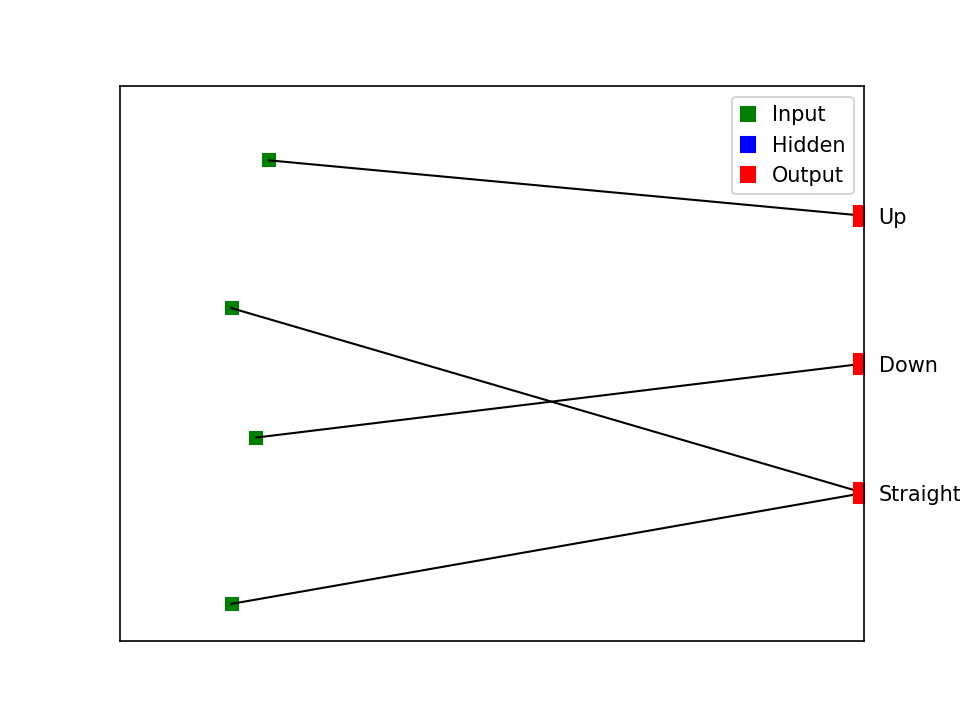

In [17]:
network_viewer_static(initialize_networks(1,3,450,3)[0])

**2) Fitness testing:**<br>
All networks are sent through the fitness function and a fitness is assigned to them. This is how far the network guided the missile down the tunnel. The further the better! <br><br>
**3) Tournament selection ** <br>
We continually put two random networks into tournament selection until we have made a population of parents for mutation.<br><br>
**4) Mutation ** <br>
The point of mutation and crossover is to make new, better networks for the next generation. During mutation, we randomly update a weight, add a connection or add a node to an existing network. The hope is to make a change that has a positive impact on the networks performance at the task. Due to the random nature of mutation (this is analagous to DNA), there is just as high a chance a mutation will be bad as good. That is why we do fitness testing and selection, to punish and remove bad mutations, and to reward and keep good mutations.<br><br>
Mutation can be exampled here:

<IPython.core.display.Javascript object>


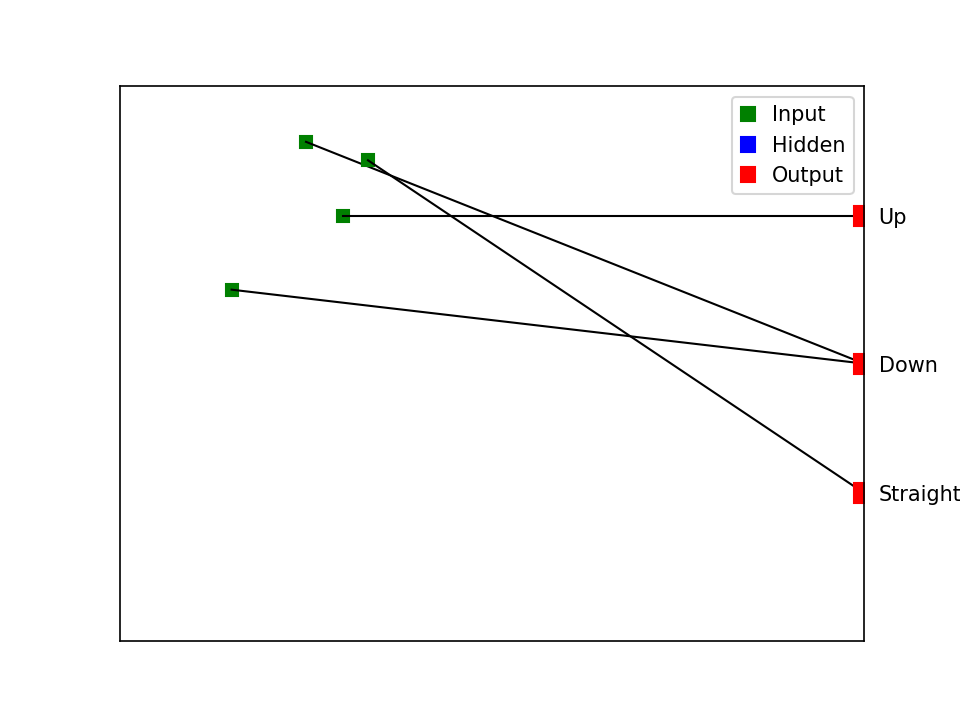

In [18]:
network = initialize_networks(1,3,450,3)[0]
network_viewer_static(network)

Give the network 5 connection addition mutations and 5 node addition mutations and watch it grow!

<IPython.core.display.Javascript object>


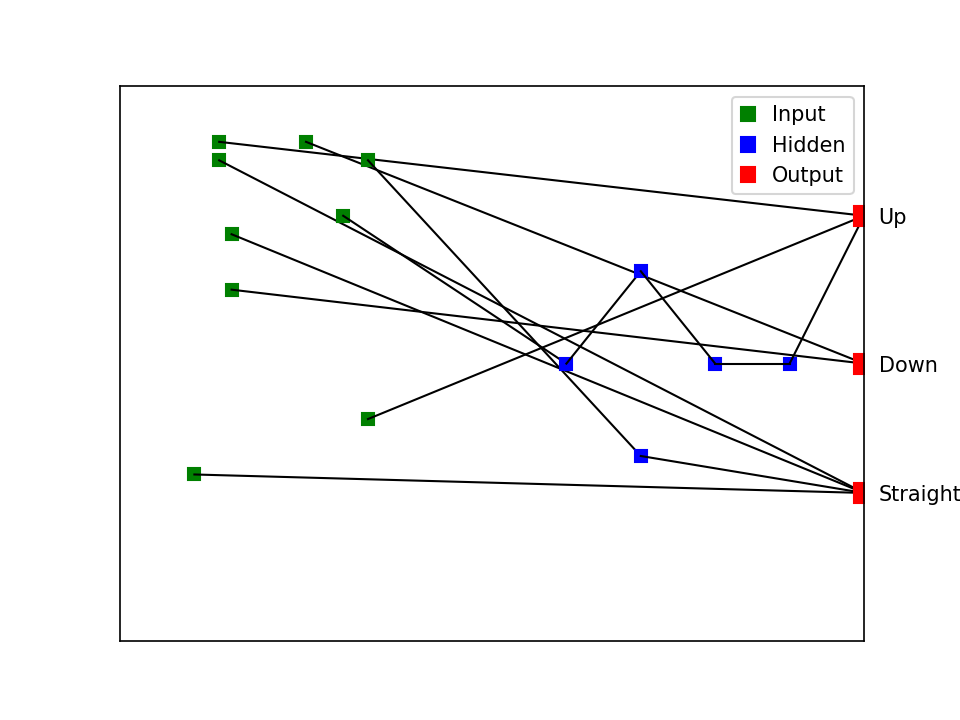

In [19]:
for i in range(5):
    connection_addition(network)
    node_addition(network)
network_viewer_static(network)

**5) Crossover:**<br>
In crossover, we take features (connections, nodes etc.) from two parents and randomize them to create an offspring. We favour taking features from the fitter parent. The aim is that this combination of features will produce an offspring with good features from both parents!<br>
**6) Recombination: ** <br>
Here we ready our offspring for the next iteration of the algorithm. The offspring are a result of Elitism, Tournament Selection, Mutation and Crossover. We need to recombine the parents and offspring so that there are the same amount going into the next iteration as came into the current iteration, thus keeping the population size consistent as the algorithm progresses.<br>
**7) Repeat! ** <br>
The algorithm coninues doing this updating the population size each time until the stopping criteria is met. The stopping criteria is when the fittest network in the population successfully guides the missile to the end of the level, or a user defined stopping fitness is reached.


## Optimizations:

**> Elitism ** <br>
We put aside our fittest network to guarantee its survival into the next generation - we dont want to risk losing it in tournament selection!<br>
**> Speciation and fitness sharing ** <br>
We separate our networks into different species dependant on structure. Networks that fall into the same species have a similar structure. We want to maintain a diverse range of structures in our population, as this increases the chance of successful mutations and allows us to explore as much of our solution space as possible. We do fitness sharing between species to decrease the chances of an individual species becoming dominant/ monopolising the population. When a new successful species enters the population, and it grows because it is the fittest, we decrease its fitness in proportion to how many of that species there are. By doing this we make it virtually impossible for the species to take over the population. <br>
**> Punishing over complexity ** <br>
In the NEAT algorithm, we start of with very basic networks, with connetions only between input and output nodes. As the algorithm progresses, we only make additions to networks that result in positive fitness changes. This is so the network doesnt grow out of hand and mutations that are redundant are not kept. Networks with redundant connections and nodes are less likely to have useful adaptations.<br>
**> Temperature function ** <br>
A temperature function governs the mutation severity that is done to a population of networks at any given time. The number of mutations exponentailly decreasing as the algorithm progresses and the temperature 'cools'. The point of this is that we want to do severe mutations at the start for larger changes in the networks. This allows us to explore a large area of our solution space as we are generating so many unique and different networks. However, as the temperature decreases throughout the iterations, the number of mutations we do to a network also decreases. This is so we make smaller changes to an existing diverse population of networks and refine these networks so they can potentailly complete the taks. When the populations average network fitness gets within a thresholded value of the best network fitness the temperature resets to its starting value. This is because when the average population fitness is very close to the best fitness most likely all the networks are quite similar, so the algorithm may have become stuck in a local maximum in the fitness landscape. To escape this local maximum, we increase the temperatre, thus increasing the severity of mutations as if it were the start of the algorithm.

**Inputs** : <br>
networks_master - *the population of networks that has been initialized and passed into the algorithm*  <br>
stopping_fitness - *the algorithm will terminate when the fittest network in the population reaches this fitness* <br>
temperature - *the starting temperature, which decides how severe our mutations are during early stages of the algorithm* <br>

**Outputs** : <br>
networks_master - *the list of all networks in our final population*
networks_generations_fittest - *a list of the fittest networks from the generations where positive changes took place*

In [23]:
def Genetic_Algorithm(networks_master, stopping_fitness, temperature): 
    
    #initialization parameters    
    %matplotlib notebook
    generation = 0
    adaptation_number = len(networks_master)
    avg_fitness_generations = []
    avg_complexity_generations = []
    max_fitness_generations = []
    networks_fittest_generations = []
    networks_fittest_generations.append(networks_master[0])
    stopping_condition = networks_master[0].fitness
    networks_generations_fittest = []
    fig, ((ax41,ax42),(ax43,ax44)) = plt.subplots(nrows=2,ncols=2, figsize=(10,10))
    
    #keep going until our best network is better than the stopping fitness!
    while stopping_condition < stopping_fitness:

        #test all networks fitness's
        total_fitness = 0
        total_complexity = 0
        for network in networks_master:
            fitness = fitness_function(network)
            total_fitness += fitness
            total_complexity += network.complexity
            network.fitness = fitness
           
        avg_fitness = total_fitness/len(networks_master)
        avg_fitness_generations.append(avg_fitness)
        avg_complexity_generations.append(total_complexity/len(networks_master))
        
        ax43.cla()
        ax43.plot(avg_complexity_generations)
        ax43.grid(linestyle='dotted')
        ax43.set_title('Avg. Network Complexity')
        ax43.set_xlabel('Generation')
        ax43.set_ylabel('Complexity')
        ax43.tick_params(axis='y',left=False, labelleft=True)
        ax43.set_yticklabels([])
        
        #sort and print them
        networks_master = sorted(networks_master, key=lambda x: x.fitness, reverse = True)
        #remove the last network to fit the elite network back in at some point
        networks_master = networks_master[:-1]
        
        #for graph
        max_fitness = networks_master[0].fitness
        max_fitness_generations.append(max_fitness)
        
        #see if the avg and max fitness are close
        threshold = 3
        if max_fitness - avg_fitness <= threshold:
            temperature =100

        ax41.cla()
        ax41.plot(avg_fitness_generations,label='Avg. Fitness')
        ax41.plot(max_fitness_generations,label='Fittest Network')
        ax41.grid(linestyle='dotted')
        ax41.set_title('Fitness Tracker')
        ax41.set_xlabel('Generation')
        ax41.set_ylabel('Fitness (%)')
        ax41.set_ylim(0,100)
        ax41.legend(loc=2)        
        
        #record the fittest thing if it has increased in fitness
        fitness1 = networks_fittest_generations[-1].fitness
        fitness2 = networks_master[0].fitness
        if fitness2 > fitness1:
            networks_fittest_generations.append(networks_master[0])
            
            # producing a static plot of the fittest network
            layers=[]
            active_neurones=[]
            outgoing =[]

            labels = ["Up","Down","Straight"]
            ylabels = [(height//4),((2*height)//4),((3*height)//4)]
            msize = 6
            lwidth = 1

            input_x = 15
            input_y = 30

            neurones = networks_fittest_generations[-1].neurones

            for neurone in neurones:
                layers.append(neurone.layer)
                if neurone.outgoing_connections:
                    active_neurones.append(neurone.id)
                    sublist = []

                    for c in neurone.outgoing_connections:

                        sublist.append(c.neurone_end.id)

                    outgoing.append(sublist)

            data_pos = []

            # create array of plot coordinates for input neurones
            for y in range (0,input_y):
                for x in range (0,input_x):
                    data_pos.append([x+6,y])

            # create array of plot coordinates for output neurones
            for i in range (1,4):
                data_pos.append([height*2,((i*height)//4)])

            # create list of hidden layers
            hidden_layers = list(set(layers))
            hidden_layers.remove(0)
            hidden_layers.remove(len(set(layers))-1)

            # assign hidden neurones plot coordinates
            for i in range(0,len(hidden_layers)):
                pos_x = (((i+1)*height)//(len(hidden_layers)+1)) + height
                pos_y = []
                for j in range(0,layers.count(hidden_layers[i])):
                    pos_y.append(((j+1)*height)//(layers.count(hidden_layers[i])+1))
                    data_pos.append([pos_x,pos_y[j]])

            active_layers = []

            for i in range(0,len(active_neurones)):
                if active_neurones[i] >= input_x * input_y:
                    active_layers.append(layers[active_neurones[i]])

            hidden_active_neurones = active_neurones[(len(active_neurones)-len(active_layers)):len(active_neurones)]
            hidden_active_neurones = [hidden_active_neurones for _,hidden_active_neurones in sorted(zip(active_layers,hidden_active_neurones))]
            active_data_pos = data_pos[(len(data_pos)-len(active_layers)):len(data_pos)]
            active_data_pos = [active_data_pos for _,active_data_pos in sorted(zip(hidden_active_neurones,active_data_pos))]

            for i in range(0,len(active_layers)):
                data_pos.pop()

            for i in range(0,len(active_layers)):
                data_pos.append(active_data_pos[i])
            
            ax44.cla()
            
            ax44.tick_params(axis='x',bottom=False,labelbottom=False)
            ax44.tick_params(axis='y',right=False, labelright=True)
            ax44.tick_params(axis='y',left=False, labelleft=False)
            ax44.set_xlim(0, 2*height)

            # plot active/inactive neurones and connections
            for i in range(0,len(active_neurones)):
                if active_neurones[i] <= (input_x*input_y):
                    act_neurone = 'gs'
                else:
                    act_neurone = 'bs'

                act_conn = 'k-'

                ax44.plot(*zip(data_pos[active_neurones[i]]),act_neurone,markersize=msize)

                for k in range(0,len(outgoing[i])):
                    ax44.plot([data_pos[active_neurones[i]][0],data_pos[outgoing[i][k]][0]]
                             ,[data_pos[active_neurones[i]][1],data_pos[outgoing[i][k]][1]],act_conn,linewidth=lwidth)

            ax44.plot(*zip(data_pos[(input_x*input_y)]),'rs',markersize=10)
            ax44.plot(*zip(data_pos[(input_x*input_y)+1]),'rs',markersize=10)
            ax44.plot(*zip(data_pos[(input_x*input_y)+2]),'rs',markersize=10)

            red_patch = mpatches.Patch(color='red', label='The red data')
            blue_patch = mpatches.Patch(color='blue', label='The blue data')

            legend_elements = [mpatches.Patch(color='g', label='Input'),
                              mpatches.Patch(color='b', label='Hidden'),
                              mpatches.Patch(color='r', label='Output')]

            ax44.set_yticks(ylabels)
            ax44.set_yticklabels(labels)
            ax44.legend(handles=legend_elements, handlelength=0.7)
            ax44.set_ylim(0,30)
            ax44.set_title('Fittest Network')
            ax44.invert_yaxis()

        #one elitism
        elite_networks = networks_master[:1]
        
        #fitness sharing
        #find out how many are of each different network id
        network_species_dict = {}
        for network in networks_master:
            if network.species_id in network_species_dict.keys():
                network_species_dict[network.species_id] += 1
            else:
                network_species_dict[network.species_id] = 1 
        
        #divide each networks fitness by how many other of the same type of network there are
        for network in networks_master:
            divisor = network_species_dict[network.species_id]
            network.temp_fitness = network.fitness / divisor
            
        #tournament selection
        #you could come out of tournament selection with multiple of the same copy of a network
        selection = tournament_selection(networks_master, len(networks_master) )
        
        #make a copy of every network so when we edit a network it doesnt edit every fucking copy of it
        parents = []
        for network in selection:
            parents.append(copy.deepcopy(network))
        del selection
        
        elite = []
        for network in elite_networks:
            elite.append(copy.deepcopy(network))
        del elite_networks
        
        #simulated annealing -> we decrease the amount of mutations that occur the longer the algorithm runs
        max_mutation = 7
        try:
             calc = int ( max_mutation - math.exp( 10 / temperature  ) )
        except OverflowError:
             calc = 1

        mutation_amount =  calc if calc > 1 else 1
        #print('temp: ',  temperature,  'number of mutations: ', mutation_amount)
        temperature *= 0.9
        mutation_prob = 10 
        
        #if the average and fittest are not close make small mutations to the population

        for network in parents:
            #at the moment when you change one networks id you change all of that types id
            #needs to become a seperate network
            if rand.randint(0,100) <= mutation_prob:
                new_species = False
                #we change how much we mutate them as we progress through the algorithm 
                for i in range(mutation_amount):
                    r = rand.randint(0,99)
                    if r < 33: #33% chance
                        network = weight_mutation(network)
                    elif 33 <= r < 66: #33% chance
                        network = connection_addition(network)
                        new_species = True
                    else:#33% chance
                        network = node_addition(network)
                        new_species = True

                if new_species:
                    #now we dont update the network id's we just update the network species when we create a new type of network
                    network.species_id = adaptation_number
                    network.id=adaptation_number
                    adaptation_number += 1
                    #maybe break out of this loop now?
                    break
                        
        generation+=1
        parents = elite + parents
        networks_master = copy.deepcopy(parents)
        
        #pie only plot every other generation
        if generation%2 == 0:
            networks_master_sorted = sorted(networks_master, key=lambda x: x.species_id)

            species = []
            species_count = []
            pie_colours = []

            for i in networks_master_sorted:
                species.append(i.species_id)
            
            species_unique = list(sorted(set(species),reverse=True))
            
            for i in range(0,len(species_unique)):
                species_count.append(species.count(species_unique[i]))
                pie_colours.append(cm.prism(species_unique[i]%20))

            ax42.cla()
            ax42.pie(species_count,labels=species_unique,colors=pie_colours,startangle=90)
            ax42.set_title('Species Dominance')
            
        fig.canvas.draw()   
        del parents
        gc.collect()
        stopping_condition = networks_master[0].fitness
        
    networks_master = sorted(networks_master, key=lambda x: x.species_id, reverse = True)
    return networks_master, networks_fittest_generations

# Make a level and run the algorithm

First make a level with the level generator function

<IPython.core.display.Javascript object>


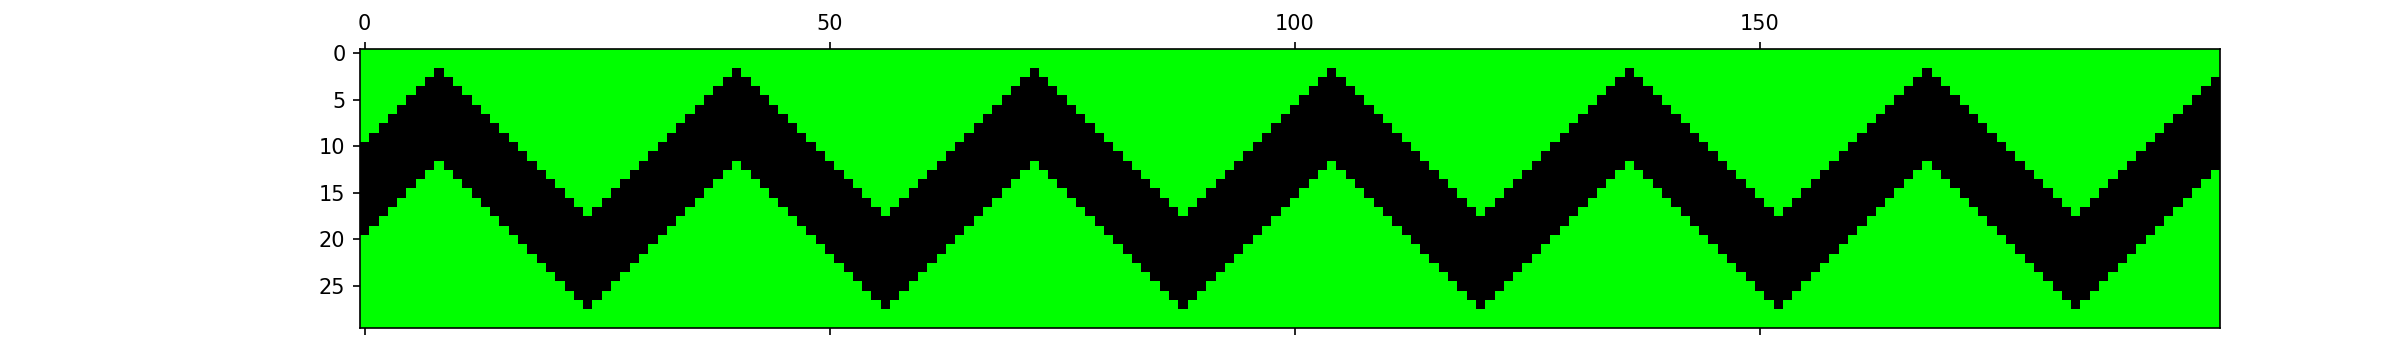

In [24]:
#prob(60<r/70<=r<90/else)
#90 (50) 
#100-90 prob (^^)

#prob 33 33 33

num = 30
rand.seed(num)
np.random.seed(num)
#1 (70) 93 (200) 89 (125) 168 (70 3)

level_generator(30,200,1)

Now we initialize 100 networks to be fed into the genetic algorithm and begin the genetic algorithm.

<IPython.core.display.Javascript object>


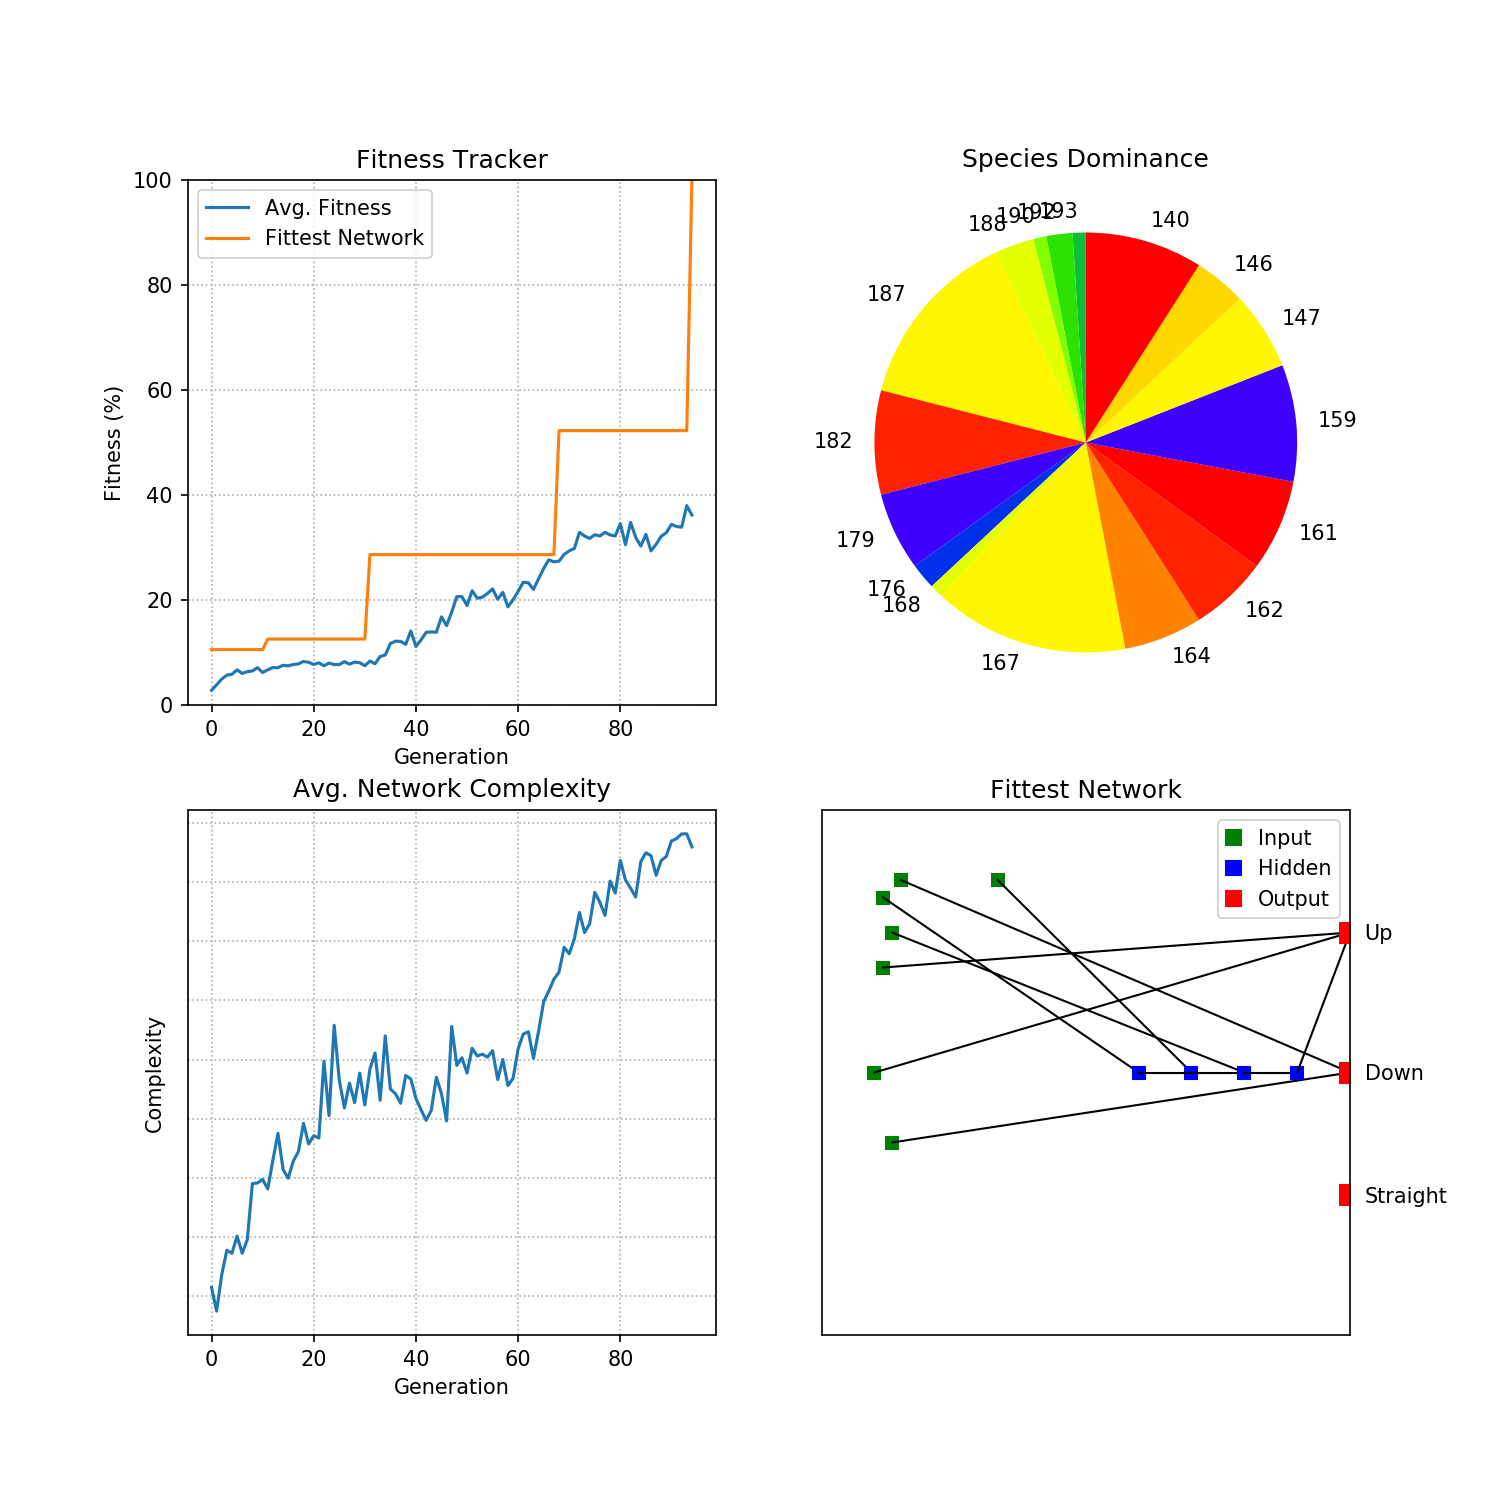

In [25]:
networks_master = initialize_networks(100,2,450,3)
ga_result, networks_generations = Genetic_Algorithm(networks_master, 100 ,100)

Now we can view information about the fittest networks throughout the training:

In [26]:
for n in networks_generations:
    print('Network species: ', n.species_id, ' Network fitness: ',n.fitness)

Network species:  0  Network fitness:  2.0100502512562812
Network species:  10  Network fitness:  10.552763819095476
Network species:  110  Network fitness:  12.562814070351758
Network species:  130  Network fitness:  28.643216080402013
Network species:  167  Network fitness:  52.26130653266332
Network species:  193  Network fitness:  100.0


## Network viewer

Now we have our networks each generation in training, we can view what they looked like as they evolved and how they improved at guiding the missile down the tunnel:

This is the fittest network from initialization:

<IPython.core.display.Javascript object>


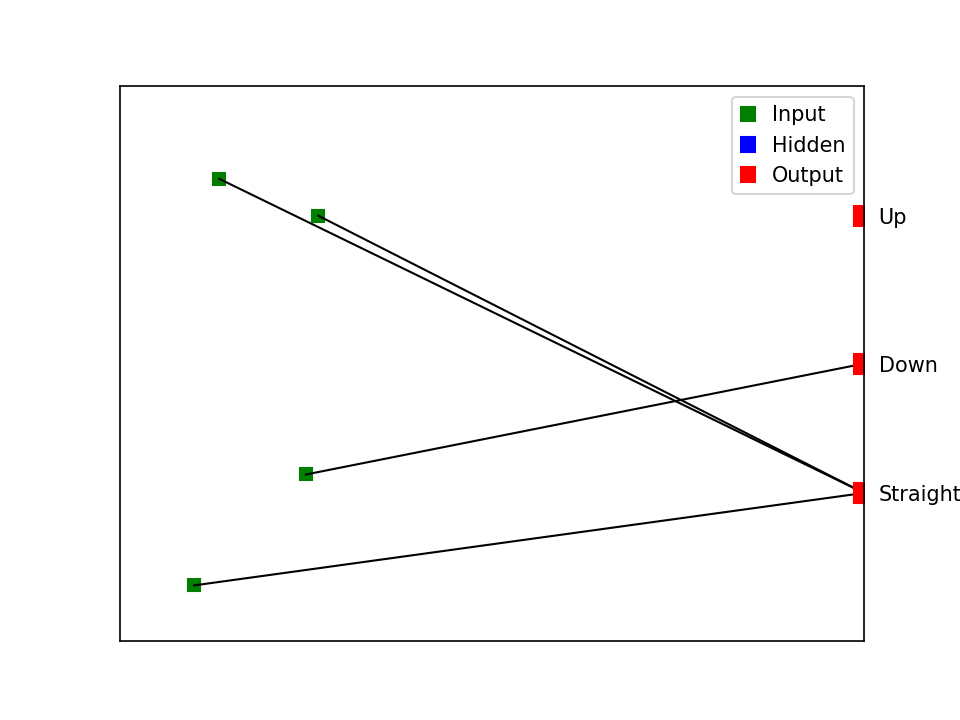

In [28]:
network_viewer_static(networks_generations[0])

And this is that network navigating the missile down the tunnel:

<IPython.core.display.Javascript object>


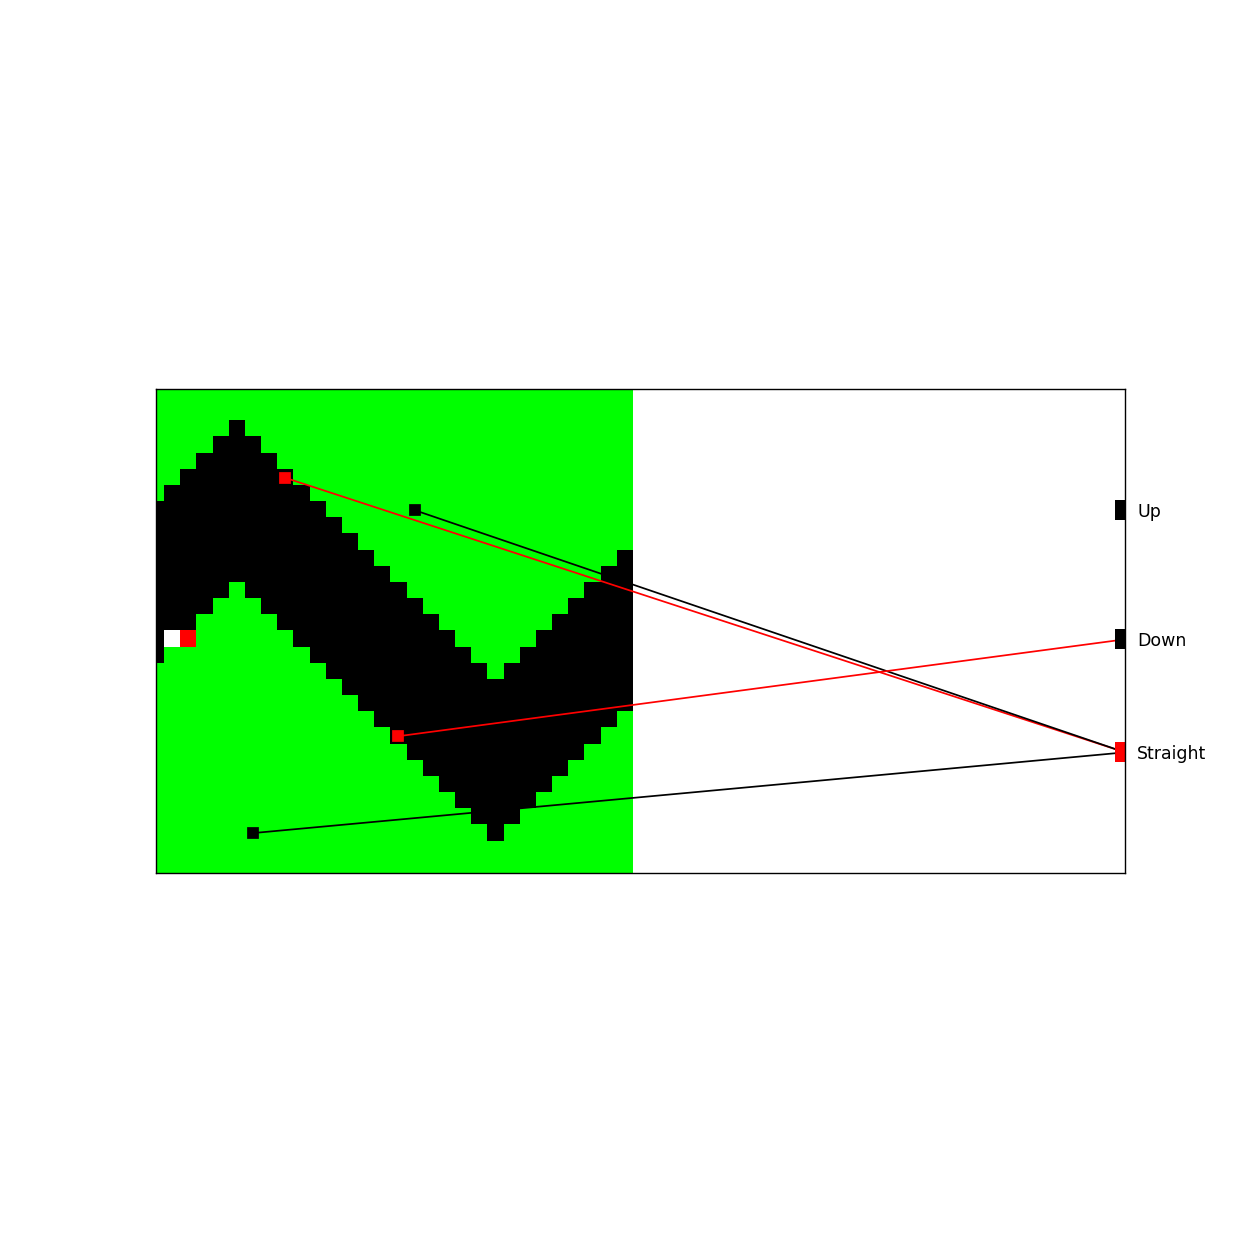

Network 0 : 2.0100502512562812 %


In [29]:
network_viewer_dynamic(networks_generations[0],0.02)

It didn't do particularly well! As the missile moves from right to left, the network is fed information from the input grid. Nodes in the input space (red/ black squares connected to the outputs) activate when they are in the black tunnel and deactivate when they are in the green tunnel wall. When they activate, the nodes fire a signal to the output nodes, and the strength of this firing is dependant on the weight between the input and output node. The missiles Up / Down / Straight move is dependant on which output node recieves the strongest activation from nodes that connect to it. A red line represents an active connection.

Now we can track the networks as they evolve and improve themselves throughout the algorithm, lets have a look at the fittest network from generation 10 when the max fitness of the population increased to 12%:

<IPython.core.display.Javascript object>


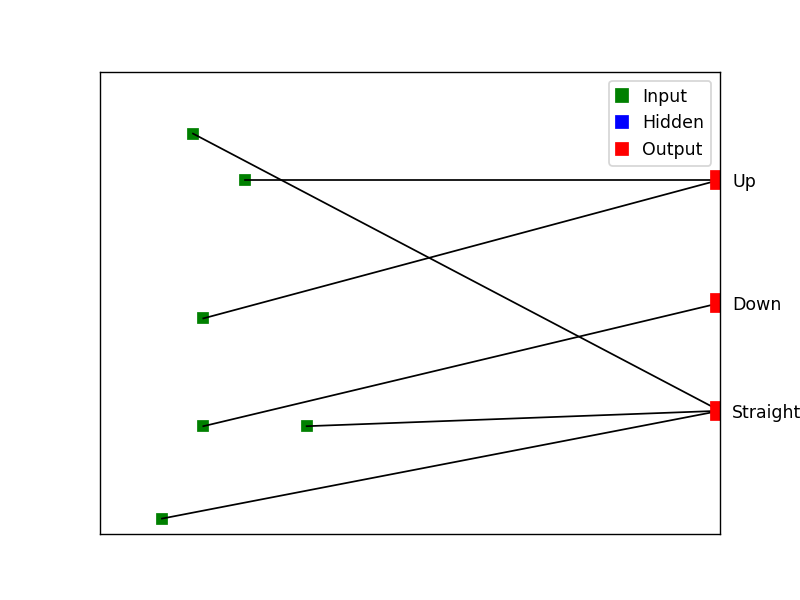

In [32]:
network_viewer_static(networks_generations[1])

<IPython.core.display.Javascript object>


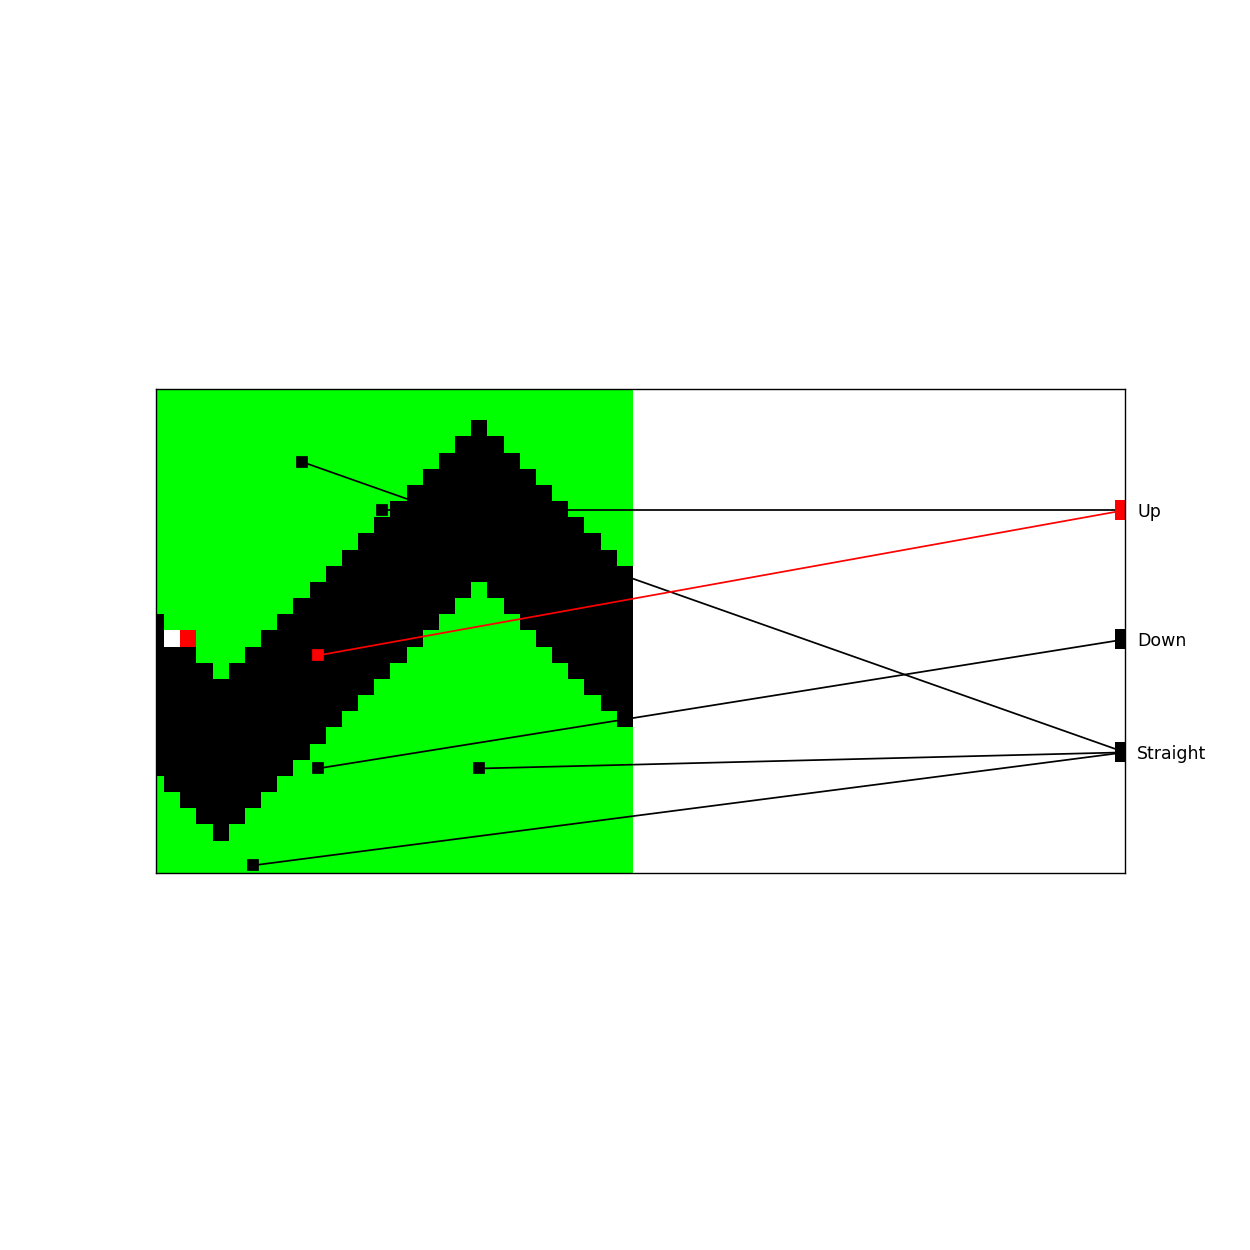

Network 10 : 10.552763819095476 %


In [33]:
network_viewer_dynamic(networks_generations[2],0.02)

As we can see, this network has mutated and is able to make better decisions that are suited to solving this task. We can keep viewing the network every time it evolves and improves:

<IPython.core.display.Javascript object>


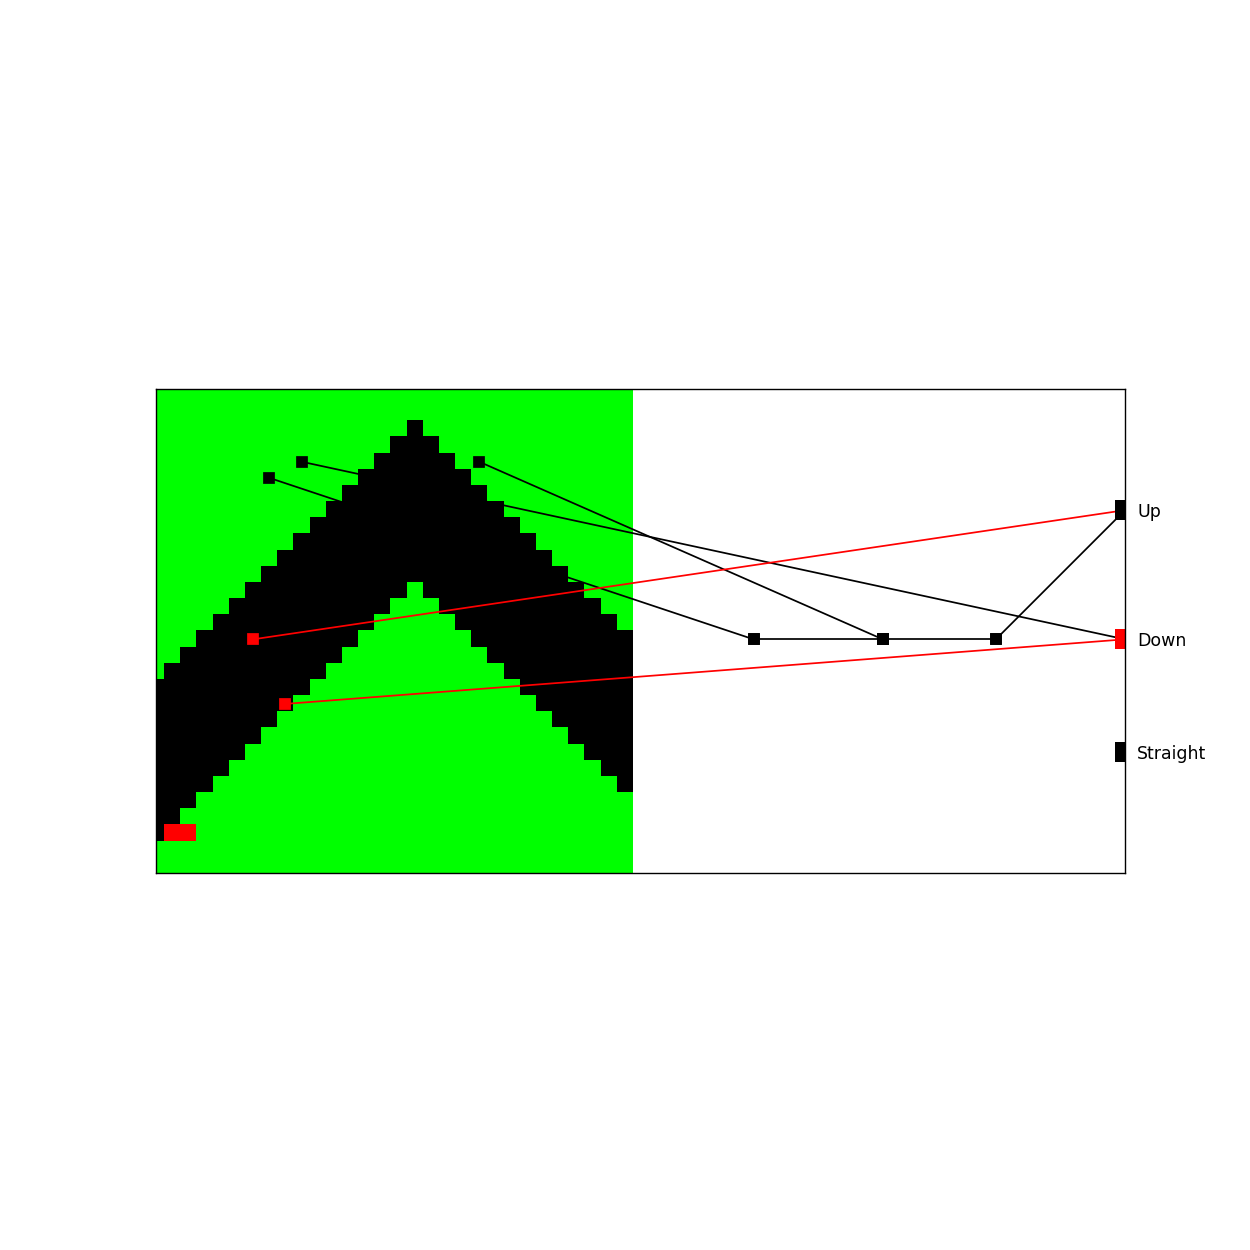

Network 130 : 28.643216080402013 %


In [34]:
network_viewer_dynamic(networks_generations[3],0.02)

Here, the mutation that added some hidden layers (nodes between the inputs and outputs) has introduced non-linearity into the system. The implication of this is that the network can start to make more intricate decisions. Lets look at the next mutation that lead to an increase in fitness:

<IPython.core.display.Javascript object>


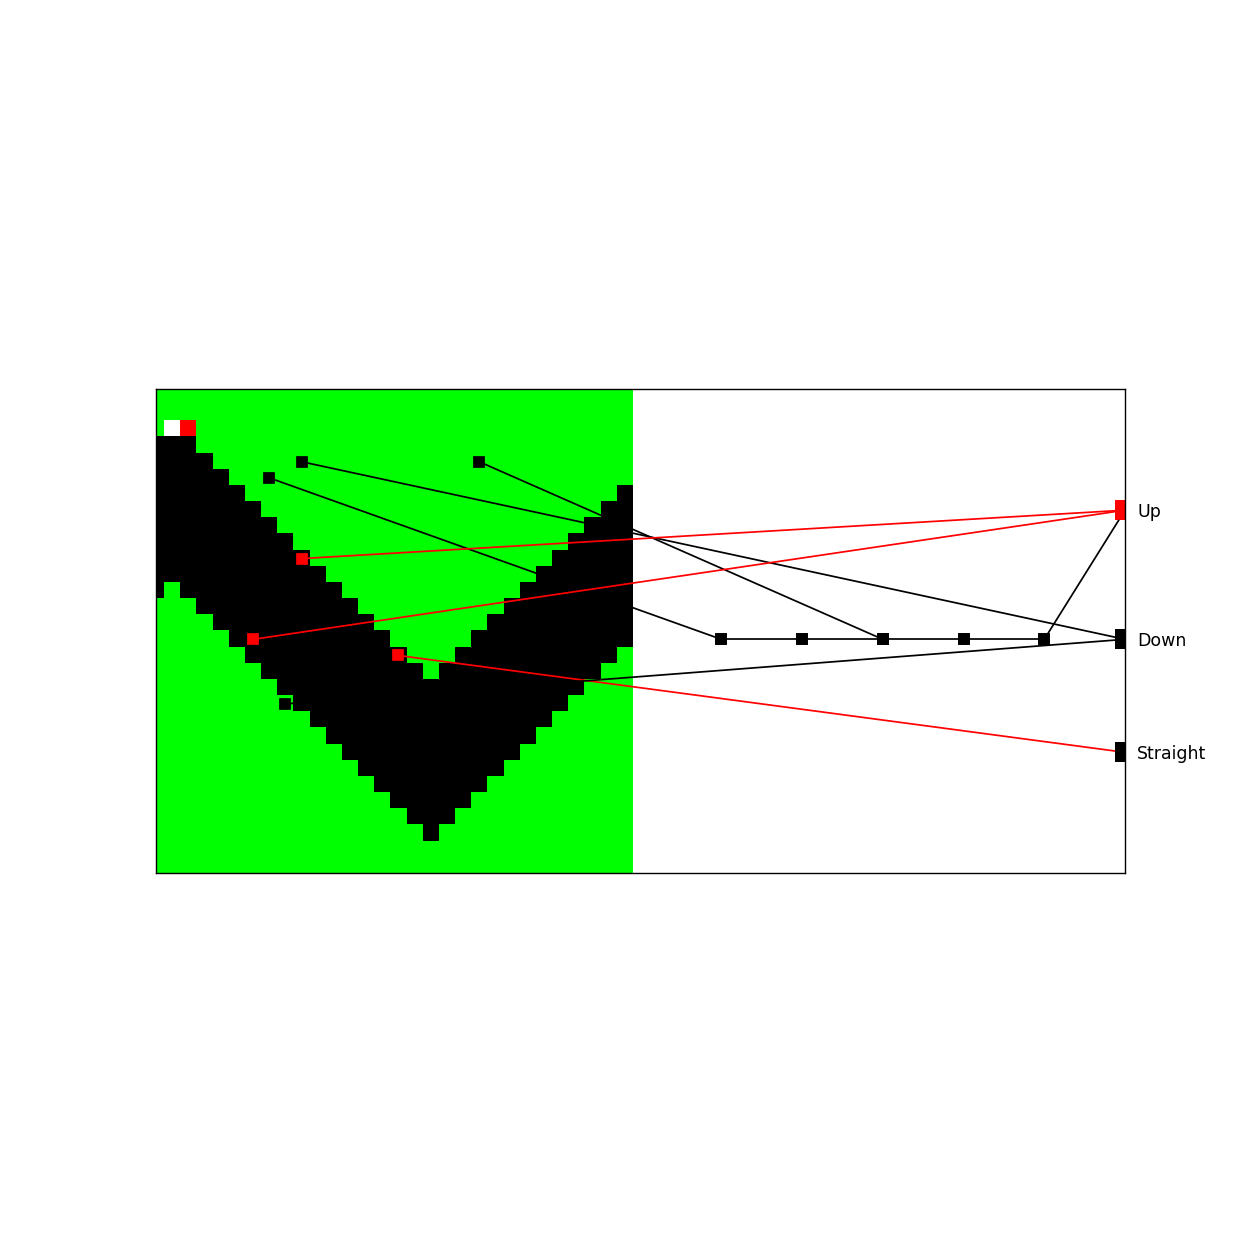

Network 167 : 52.26130653266332 %


In [35]:
network_viewer_dynamic(networks_generations[4],0.02)

<IPython.core.display.Javascript object>


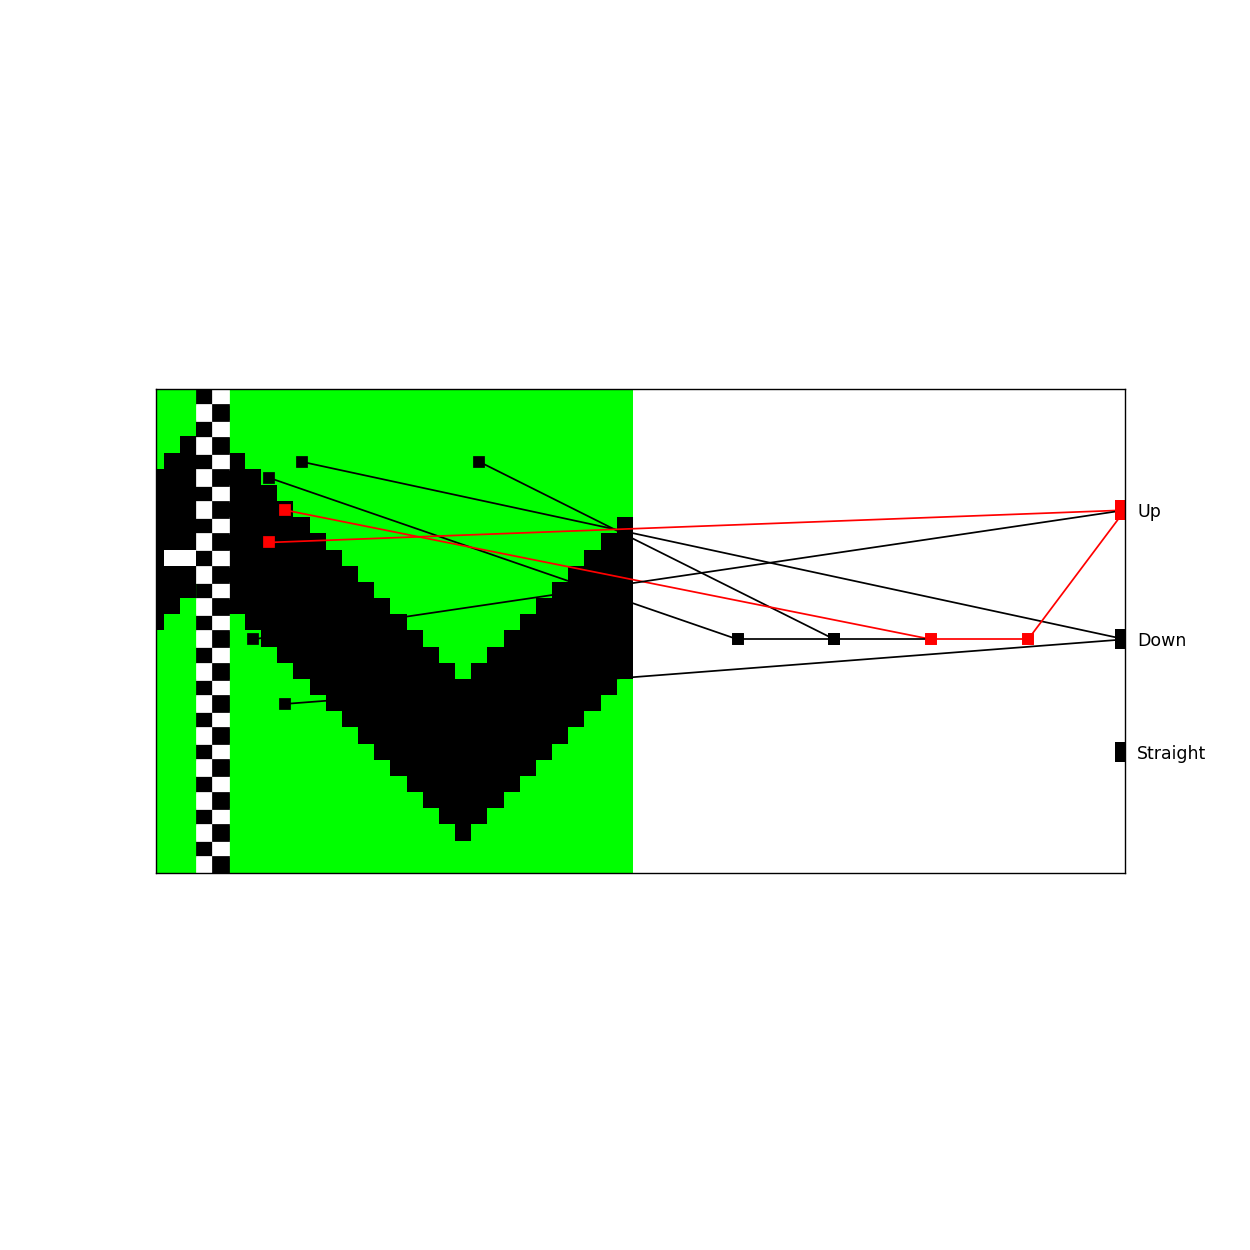

Network 193 : 100.0 %


In [36]:
network_viewer_dynamic(networks_generations[5],0.02)

Finally! Our fittest network from generation 90 has solved the level!

# Business Application

We have created a NEAT framework that can be used to solve many different types of tasks. NEAT has been used to solve tasks such as optimizing antena shapes on spacecraft and optimizing wheel shapes on F1 cars. This NEAT framework could be used to solve any task that can be described in a 2D grid of pixels. <br> A network could be taught to play any game that can be represented in this 2D grid space. This is a hugely powerful tool with potential to be used in R&D and with customers. The network visualization gives the user an intuition as to what is happening in their program whereas most neural network interfaces are black boxes with little to no idea what is going on inside.<br>
The program itself is modular so that the missile guidance interface could be unplugged easily and a new interface for training could be plugged straight in.

# Fin

*This project was created from scratch by Alex Kendall (NEAT Algorithm) and Ed Cox (Network & Data Visualization) for the Fujitsu "Hello AI" Hackathon.*